---
title: "Simple Linear Regression"
author: "Brandon Scott"
date: "2022-12-24"
categories: [analysis, bayesian]
draft: false
toc: true
number-sections: true
crossref:
    chapters: true
format:
    html:
        code-fold: false
jupyter: python3
---

## Introduction

The hope of this analysis is to demonstrate that there is a quantifiable relationship between GPA and study hours. We recognize that the collected data was self reported and therefore can be dishonest. Nonetheless, our goal is to still find a way to quantify a relationship between GPA and study hours to:
<ol>
    <li>Gather inference to determine how GPA changes based on increase study time</li>
    <li>Predict what a student's GPA would be based on study time</li>
</ol>

Data for this analysis can be found [here](https://www.kaggle.com/datasets/joebeachcapital/gpa-study-hours)

## Exploratory Data Analysis (EDA)

### Import data and libraries

We begin our analysis by importing the following libraries to create data visualizations as well as properly format and filter our data.

In [1]:
#| eval: false

#Import libraries
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#| echo: false
### ONLY RUN ONCE ###
#Download dataset
#od.download("https://www.kaggle.com/datasets/joebeachcapital/gpa-study-hours")

In [3]:
#| echo: false

#Create dataframe from file
df = pd.read_csv("kaggle_datasets//gpa-study-hours/gpa_study_hours.csv")

We read in our data using pandas and will use the head function to check out the data. 

In [4]:
#Check dataframe
df.head()

,gpa,study_hours
0,4.00,10.0
1,3.80,25.0
2,3.93,45.0
3,3.40,10.0
4,3.20,4.0


The head result indicates that the data has been read in correctly. In the next section, we will begin to clean the data.

### Data Cleaning

We will begin our data cleaning by getting some basic summary statistics from the dataframe.

In [5]:
#Describe dataset
df.describe()

,gpa,study_hours
count,193.000000,193.000000
mean,3.586166,17.476684
std,0.285482,11.408980
min,2.600000,2.000000
25%,3.400000,10.000000
50%,3.620000,15.000000
75%,3.800000,20.000000
max,4.300000,69.000000


The resulting dataframe shows that we have 193 rows of data where on average the gpa is 3.58 with a standard deviation of .28. Average study hours show 17.47 and standard deviation of 11.4, meaning we have a large spread in the distribution of study hours but not too much in gpa. From the summary statistics, we can easily see that the max value is invalid as the scale we are using for this analysis is 0-4. We will eliminate any rows that fall outside of this range.

In [6]:
#Check datatypes
df.dtypes

gpa            float64
study_hours    float64
dtype: object

Checking the datatypes of each of the columns, we see that each is of type float. This confirms that all rows in each column are of the same datatype and, in theory, we do not need to clean up any corrupted data/poorly entered data.

In [7]:
#Check for null values
df.isnull().sum()

gpa            0
study_hours    0
dtype: int64

In addition, checking for nulls, we see there are none so we do not need to do anything with those. In the next code chunk, we will eliminate erroneous gpa entries.

In [8]:
#Convert outlier GPA (erroneous entries) to 4.0
df = df.assign(gpa = lambda x: np.where(x.gpa > 4, 4, x.gpa))

In the above chunk, we use the assign function to override the gpa column and change values that are above 4 to just 4 while leaving all others the same.

## Data Viz

The first visualization we will look at is comparing the distributions of gpa and study hours. We want to get a side by side look so we will use the subplots functionality from matplotlib. As well, we will plot the median of the two respective distributions to know where the 50% percentile lies. The following code produces @fig-dist-1. 

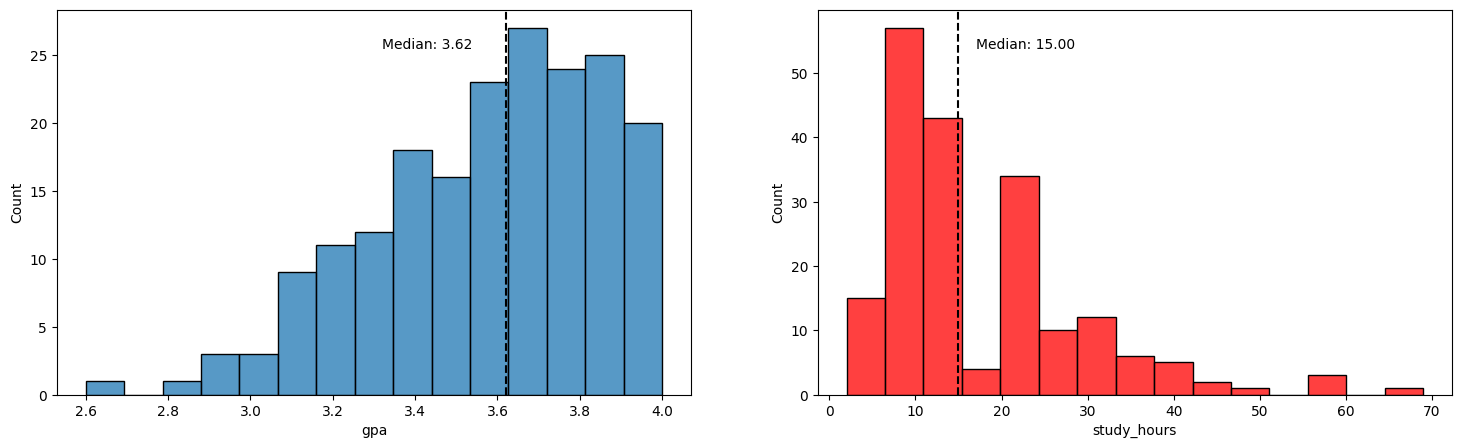

In [9]:
#| label: fig-dist-1
#| fig-cap: "Distributions of GPA and Study Hours"

# Check distributios of gpa and study hours
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 5))
sns.histplot(x="gpa", data=df, ax=ax1, bins=15)
ax1.axvline(df.gpa.median(), color="black", linestyle="dashed")
ax1.text(df.gpa.median() - 0.3, ax1.get_ylim()[1] * 0.9, f"Median: {df.gpa.median():.2f}")

sns.histplot(x="study_hours", data=df, ax=ax2, color="red", bins=15)
ax2.axvline(df.study_hours.median(), color="black", linestyle="dashed")
ax2.text(df.study_hours.median() + 2, ax2.get_ylim()[1] * 0.9, f"Median: {df.study_hours.median():.2f}");

#fig.suptitle("Distributions of GPA and Study Hours");

From @fig-dist-1, we see that GPA appears to be slightly left skewed with a couple of outliers to the left of the distribution. Study hours appears to be more right skewed with more outliers towards the right of the distribution. Median for GPA is 3.62 and 15 for study hours. 

Since we are working with two quantitative variables, we can use a scatterplot to view how linear their relationship (ie correlation) as well as view the where each gpa falls for a given amount of study hour. The below code produces @fig-scatterplot-1.

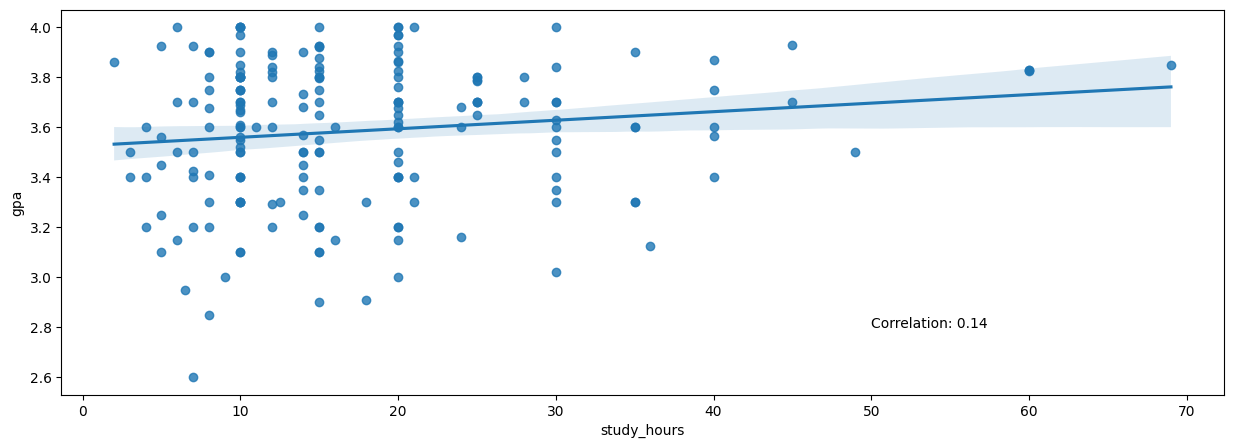

In [10]:
#| label: fig-scatterplot-1
#| fig-cap: "Scatterplot of GPA by Study Hours"

#Scatterplot of gpa and study hours
plt.figure(figsize=(15,5))
sns.regplot(x='study_hours', y='gpa', data=df)
corr_coef = np.corrcoef(df.study_hours, df.gpa)[0][1]
plt.text(50, 2.8, f"Correlation: {corr_coef:.2f}");

@fig-scatterplot-1 shows that the linear relationship between study hours and GPA is not very strong. An exact score of .14 for the correlation indicates a weak linear relationship. Further more, like we already saw from the histograms, the data appears to be more grouped towards the beginning of the x axis (0-20ish hours). 

We can attempt to adjust the distribution and correlation of the dataset by removing outliers. However, because the outlying dots appear to follow the trend of the data (more or less...) and we always like keeping as much data as possible, this is merely an optional step to fulfill our curiosity.

We will define an outlier as a point that falls outside of a box-plot range. Below is the function we will use to define and identify outliers.

In [11]:
#Identify outliers
def find_outliers(x, column_name):
    q1 = x[column_name].quantile(.25)
    q3 = x[column_name].quantile(.75)
    iqr = q3 - q1
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    outliers = x[(x[column_name] < lower) | (x[column_name] > upper)]
    
    return outliers
    

The function calculates the IQR of the dataset and then returns a filtered dataframe based on whether a point passes the upper or lower bound of the box-plot. For example, below we see how the function identifies outliers using the GPA attribute.

In [12]:
#Find outliers for gpa
find_outliers(df, "gpa")

,gpa,study_hours
108,2.6,7.0


Similarily, we can view the outliers for study hours below.

In [13]:
#Find outliers for study hours
find_outliers(df, "study_hours")

,gpa,study_hours
2,3.930,45.0
7,3.400,40.0
13,3.830,60.0
51,3.868,40.0
57,3.125,36.0
77,3.566,40.0
83,3.850,69.0
89,3.700,45.0
122,3.750,40.0
125,3.500,49.0


@fig-scatter-outliers below shows which points are labeled as outliers from our scatterplot.

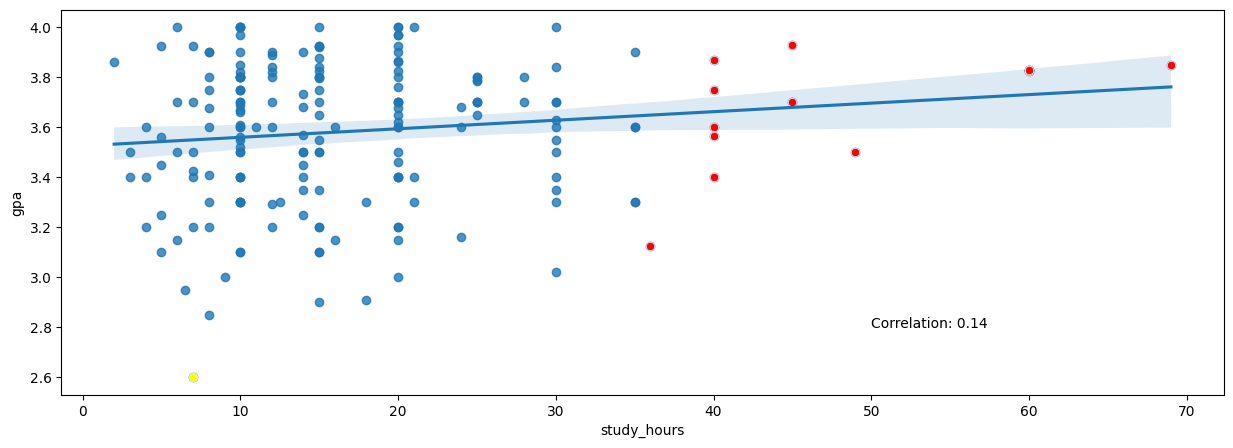

In [14]:
#| label: fig-scatter-outliers
#| fig-cap: "Scatterplot of GPA and Study Hours (highlighted outliers)"

#Plot original scatterplot
plt.figure(figsize=(15,5))
sns.regplot(x='study_hours', y='gpa', data=df)
corr_coef = np.corrcoef(df.study_hours, df.gpa)[0][1]
plt.text(50, 2.8, f"Correlation: {corr_coef:.2f}")

#Show outliers by study hours (color red)
sns.scatterplot(x='study_hours', y='gpa', data=find_outliers(df, "study_hours"), color='red')

#Show outliers by gpa (color yellow)
sns.scatterplot(x='study_hours', y='gpa', data=find_outliers(df, "gpa"), color='yellow');

As already indicated, the red dots are outliers according to the "study hours" metric while yellow indicates outlier for "gpa". While the red dots are technically "outliers", they do sort of follow the general trend and direction of the data whereas the yellow dot does not. Let's try removing the yellow dot to see how it changes the correlation of the data.

In [15]:
#Remove outliers from dataset
df_filtered = df.query("gpa > 2.6")

After removing the gpa outlier, the scatterplot and corresponding correlation are as follows.

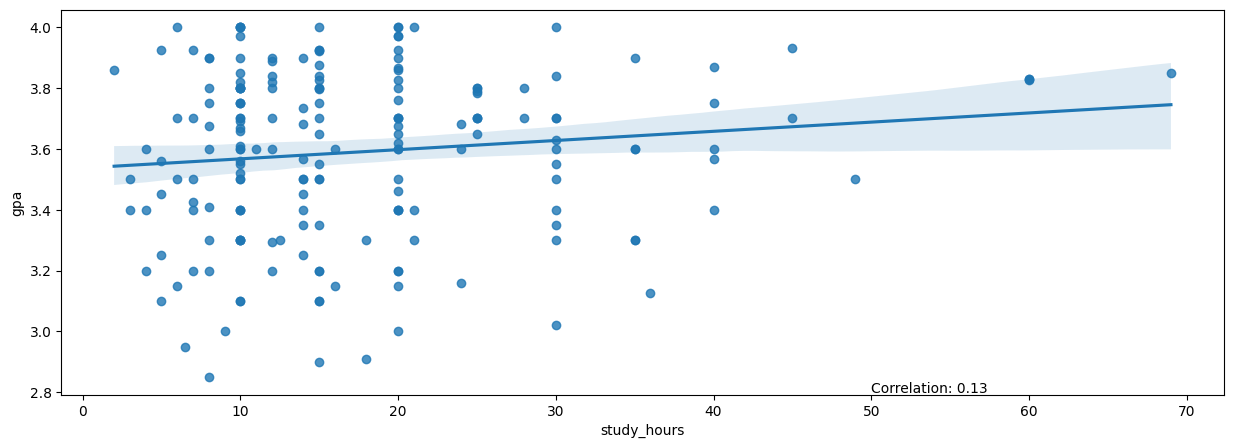

In [16]:
#| label: fig-scatterplot-2
#| fig-cap: "Scatterplot of GPA by Study Hours (filtered)"

#Scatterplot of gpa and study hours
plt.figure(figsize=(15,5))
sns.regplot(x='study_hours', y='gpa', data=df_filtered)
corr_coef = np.corrcoef(df_filtered.study_hours, df_filtered.gpa)[0][1]
plt.text(50, 2.8, f"Correlation: {corr_coef:.2f}");

We see that removing the gpa outlier had a minimal effect on the correlation (actually slightly decreased) thus "weakening" the linear relationship of the variables. Perhaps we can try a non-linear transformation to aid our non-linear data.

To do this, we will perform a log transformation on both gpa and study hours (on our original dataset) and a polynomial transformation on study hours. Below is the result of our transformations.

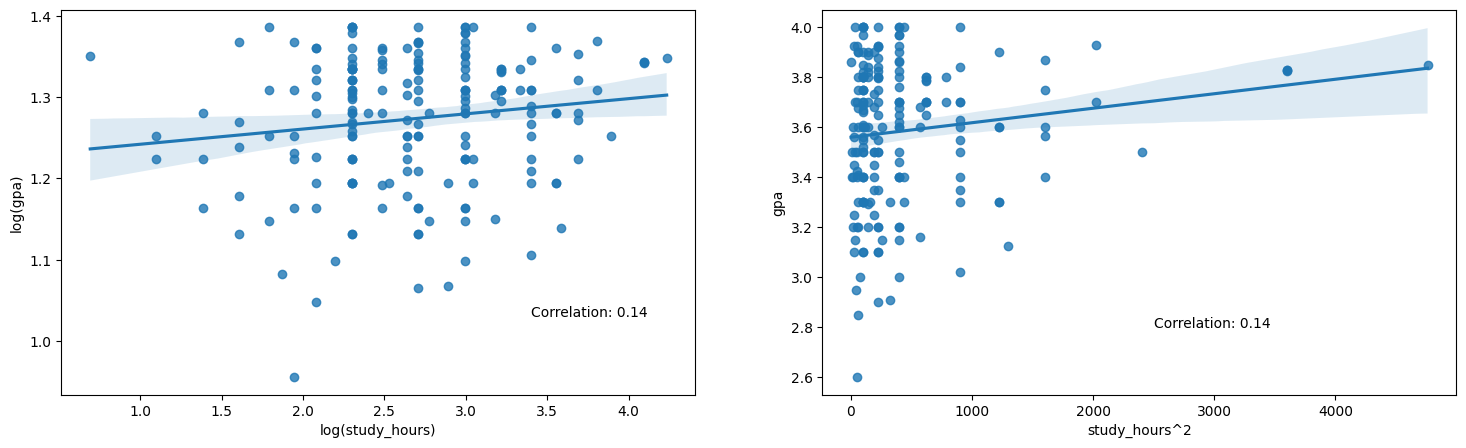

In [17]:
#| label: fig-transformations
#| fig-cap: "Scatterplot of GPA by Study Hours (filtered)"

#Plot log transformed data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 5))
sns.regplot(x='study_hours', y='gpa', data=np.log(df), ax=ax1)
ax1.set_xlabel("log(study_hours)")
ax1.set_ylabel("log(gpa)")
corr_coef = np.corrcoef(df.study_hours, df.gpa)[0][1]
ax1.text(np.log(30), np.log(2.8), f"Correlation: {corr_coef:.2f}")

#Plot polynomial transformed data
df_poly = df.assign(study_hours = lambda x: x.study_hours**2)
sns.regplot(x='study_hours', y='gpa', data=df_poly, ax=ax2)
ax2.set_xlabel("study_hours^2")
corr_coef = np.corrcoef(df.study_hours, df.gpa)[0][1]
ax2.text(50**2, 2.8, f"Correlation: {corr_coef:.2f}");

In @fig-transformations, we see that our transformations really had not effect on the linear relationship. For the sake of getting on with the modeling, we will use our base dataset and interpret the model accordingly (barring that the other model assumptions hold).

## Classical Modeling

This section will be our first attempt at modeling the data, using classical (frequentist) style approaches. Even though this is thebayesianbandit, I like providing frequentist approaches as well to show the differences and similarities between normal statistical modeling (frequentist) and bayesian modeling. 

### Linear Regression Framework

Since we are dealing with "linear" data, it would make sense to attempt to attempt to fit a linear model to the data. Therefore, we will be utilizing a simple linear regression (SLR) model to model the relationship between GPA and study hours (per week). Below is the equation we will use.

$$
y = X\beta + \epsilon 
$${#eq-linear-model}
$$\epsilon \sim N(\mu, \sigma^2)$$

@eq-linear-model models our response variable is equal to our matrix of explanatory variables (in this case, just one) multiplied (scaled) by a matrix of betas, plus errors (residuals) that are distributed normally with mean $\mu$ and variance $\sigma^2$

In linear algebra/matrix notation, it would look something like this.

$$
\begin{bmatrix}
y_1 \\
... \\
y_n
\end{bmatrix}
=
\begin{bmatrix}
1 & x_1 \\
... & ... \\
1 & x_n \\
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\
\beta_1
\end{bmatrix}
+
\begin{bmatrix}
\epsilon_1 \\
... \\
\epsilon_n 
\end{bmatrix}
$${#eq-linear-model-matrix}

We utilize ordinary least squares (OLS) to estimate our coefficients ($\beta$ values) by minimizing the residual sum of squares (RSS). Below are the equations we will use. 

$$
RSS = \epsilon^2_1 + ... + \epsilon^2_n
$${#eq-residual-sum-squares}

$$
\epsilon = y_i - \hat{y_i}
$${#eq-residuals}

$$
\hat{\beta_1} = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n}(x_i - \bar{x})^2}
$${#eq-beta-1}

$$
\hat{\beta_0} = \bar{y} - \hat{\beta_1}\bar{x}
$${#eq-beta-0}


By estimating our coefficients like this, we have a mathematical framework of estimating the line of best fit (the average line between all data points). This yields are final equation below.

$$
\hat{y} = X\hat{\beta}
$${#eq-linear-hat}

Where $\hat{y}$ is our "predicted" value based off our inputs in the matrix of $X$, scaled/multiplied by $\hat{\beta}$, our estimated coefficients.

### Calculate beta values and interpret results

Now that we have our framework by which we will fit our data, we can use Python libraries to perform the above calculations.

In [29]:
#Import statsmod and fit SLR model
import statsmodels.api as sm
y = df['gpa']
X = pd.DataFrame({'intercept':np.ones(df.shape[0]), 'study_hours':df['study_hours']})
model = sm.OLS(y, X)
results = model.fit()

In [33]:
#Print summary from SLR model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gpa   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.714
Date:                Wed, 06 Sep 2023   Prob (F-statistic):             0.0555
Time:                        20:33:28   Log-Likelihood:                -27.443
No. Observations:                 193   AIC:                             58.89
Df Residuals:                     191   BIC:                             65.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       3.5249      0.037     95.292      0.000       3.452       3.598
study_hours     0.0034      0.002      1.927      0.055   -8.05e-05       0.007
==============================================================================
Omnibus:                       10.671   Durbin-Watson:                   2.385
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.481
Skew:                          -0.595   Prob(JB):                      0.00321
Kurtosis:                       2.897   Cond. No.                         38.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the summary, we have $\beta_0$ = 3.5249 and $\beta_1$ = .0034, meaning on average someone who studies 0 hours a week would see a GPA value of about 3.5. In addition, on average, for an increase of 1 hour in study time, we would see an increase of about .0034 in GPA. This isn't too surprising considering the weak linear relationship we observed earlier in @fig-scatterplot-1. Essentially, if I were a student in this class, in order to change a whole letter grade (i.e. go from B to B+) and assuming I was right at B level (3.0), I would need to study 88 extra hours. Essentially, this model says that you're stuck where you're at. 

Nevertheless, we can gain confidence in knowing a couple of things. 
<ol>
    <li>The data has a fairly weak linear relationship, so using a linear model to fit the data may not tell the most accurate story on how GPA is influenced by study hours.</li>
    <li>The data could be inaccurate due to self-reporting</li>
</ol>

### Is study hours a statistically significant variable in determining GPA?

To determine the answer to the above question, we pose the following hypotheses.

$$
H_0: \beta_1 = 0
$$
$$
H_a: \beta_1 \neq 0
$$

The aim of these hypotheses is to determine whether or not $\beta_1$ on average always has some kind of impact on GPA (whether it is an increase or decrease, no one knows in these things). We set our $\alpha$ = .05 to run our hypotheses. 

The p-value we obtain from the summary print out indicates that p-value > $\alpha$, so we fail to reject $H_0$ and conclude that there isn't sufficient evidence to reject the null. Essentially, we don't have enough statistical evidence from the data to prove that study hours, on average, will never have a 0 impact on GPA. 

To confirm this notion, we can view the corresponding 95% confidence interval for $\beta_1$ provided in the summary tab. The values of (-.000085, .007) indicate that 0 is included in the interval and therefore, the average change on GPA based on study hours can be 0.

### Check assumptions of linear regression model

Even though the $\beta_1$ value proved to not be statistically significant (though very close), we should still verify that the assumptions of our linear model hold with this data set. The assumptions for a linear regression model are listed below.
<ol>
    <li>Linearity</li>
    <li>Independence</li>
    <li>Normality</li>
    <li>Equal Variance</li>
</ol>

We already verified that there is a weak linear relationship, but still a linear relationship since correlation was not 0. Independence is verified by the fact that each observation in the study was independent of one another, thus making them i.i.d random variables. 

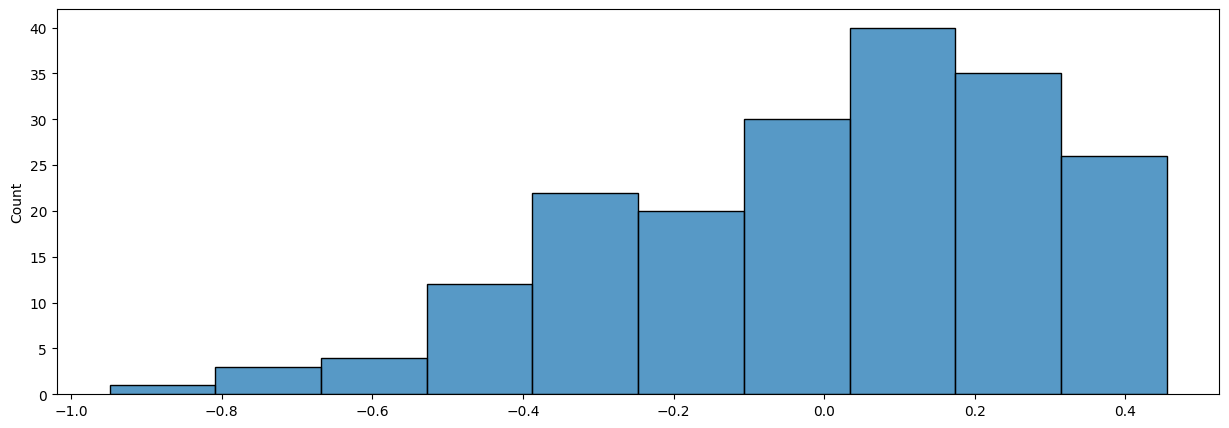

In [36]:
#| label: fig-normality
#| fig-cap: "Histogram of resiudals"

#Plot histogram of residuals
plt.figure(figsize=(15,5))
sns.histplot(results.resid);

As we can see in @fig-normality, the distribution looks fairly left skewed with a long left tail. For ease of this analysis/exercise, we will say this is "approximately" normal, but this would more than likely fail in the real world.

To verify equal variance, we will view a scatterplot of the fitted vs residual values to make sure that there appears to be equal variance (good randomness, no trends) in the graph.

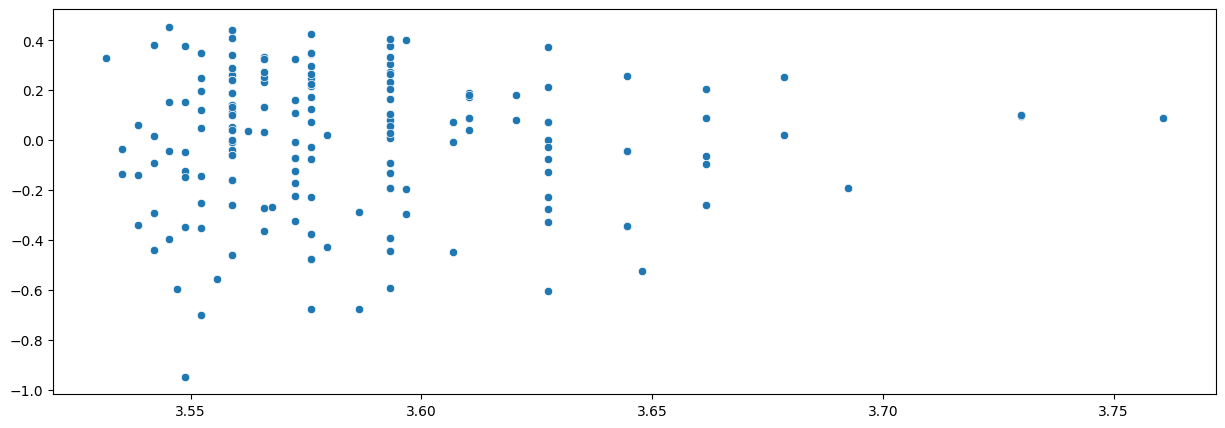

In [41]:
#| label: fig-equal-variance
#| fig-cap: "Scatterplot of fitted vs residuals"

#Plot scatterplot of fitted vs residuals
plt.figure(figsize=(15,5))
sns.scatterplot(x=results.fittedvalues,y=results.resid);

In @fig-equal-variance, there appears to be no significant trends in the data (though it does tend to begin to taper as we increase across the x-axis). However, since there is nothing obvious or glaring, we can verify this assumption.

### Do students spend on average 9 hours a week studying?

From my past university experience, many professors have told me that for every 1 hour of lecture, should be 3 hours of study/homework time. Assuming this class was a 3 credit hour class, most students should be spending about 9 hours studying outside of class. To test this theory, we will use a t-test for the following hypotheses.

$$H_0: \mu = 9$$
$$H_a: \mu \neq 9$$

In [44]:
#Perform t-test to see if students on average spend 9 hours studying
from scipy.stats import ttest_1samp
ttest_1samp(a=df['study_hours'], popmean=9)

TtestResult(statistic=10.32185697364204, pvalue=3.767865100544389e-20, df=192)

The above result with a super small p-value (less than $\alpha$ = .05) indicates that we can reject the null hypothesis and conclude that students do not study an average of 9 hours for this class. To determine what the range of possible average values are, we will calculate a 95% confidence interval below.

In [46]:
#Calculate 95% confidence interval
ttest_1samp(a=df['study_hours'], popmean=9).confidence_interval()

ConfidenceInterval(low=15.856880282374465, high=19.096487593273206)

We are 95% confident that the true average study time spent is between 15.85 to 19.09 hours. So, on average, students are spending a lot more time studying for this class than the hoped benchmark set by this university (assuming this university has set the same benchmark as my other ones).

## Bayesian Modeling

Finally, getting into the bayesian part of the analysis! As with our classical approach, we will layout the framework we will use for this section. We will be using the bayesian model (Bayes theorem) shown below. 

$$P(H|\theta) = \frac{P(\theta|H) P(H)}{P(\theta)}$${#eq-bayes-theorem}

$$H = \text{Our Hypothesis (prior)}$$
$$\theta = \text{Our Data}$$